In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, explained_variance_score
from skimage.metrics import normalized_root_mse

In [8]:
dataset = pd.read_csv('Edited_Korea_Original.csv')
df = dataset[dataset['Station code'] == 101].iloc[:,2:]
scaler = MinMaxScaler(feature_range = (0,1))
df1 = scaler.fit_transform(df)

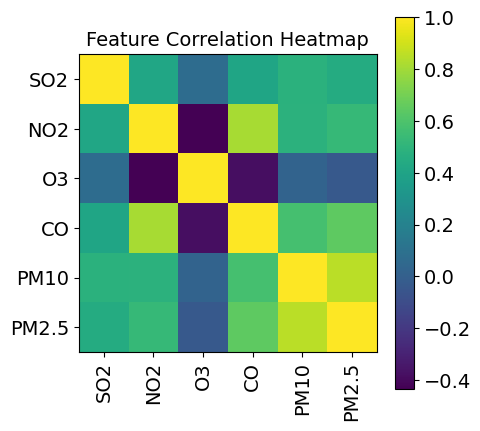

In [9]:

def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

In [10]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step)]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step])
	return np.array(dataX), np.array(dataY)

In [11]:
def create_model(X_train):
    learning_rate = 0.01
    model = Sequential()
    model.add(LSTM(128, return_sequences = True, input_shape = (X_train.shape[1:])))
    model.add(LSTM(128, return_sequences = True))
    model.add(LSTM(128, return_sequences = True))
    model.add(LSTM(128))
    model.add(Dense(X_train.shape[2]))
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = learning_rate), loss = "mean_absolute_error", metrics = ['accuracy'])
    return model

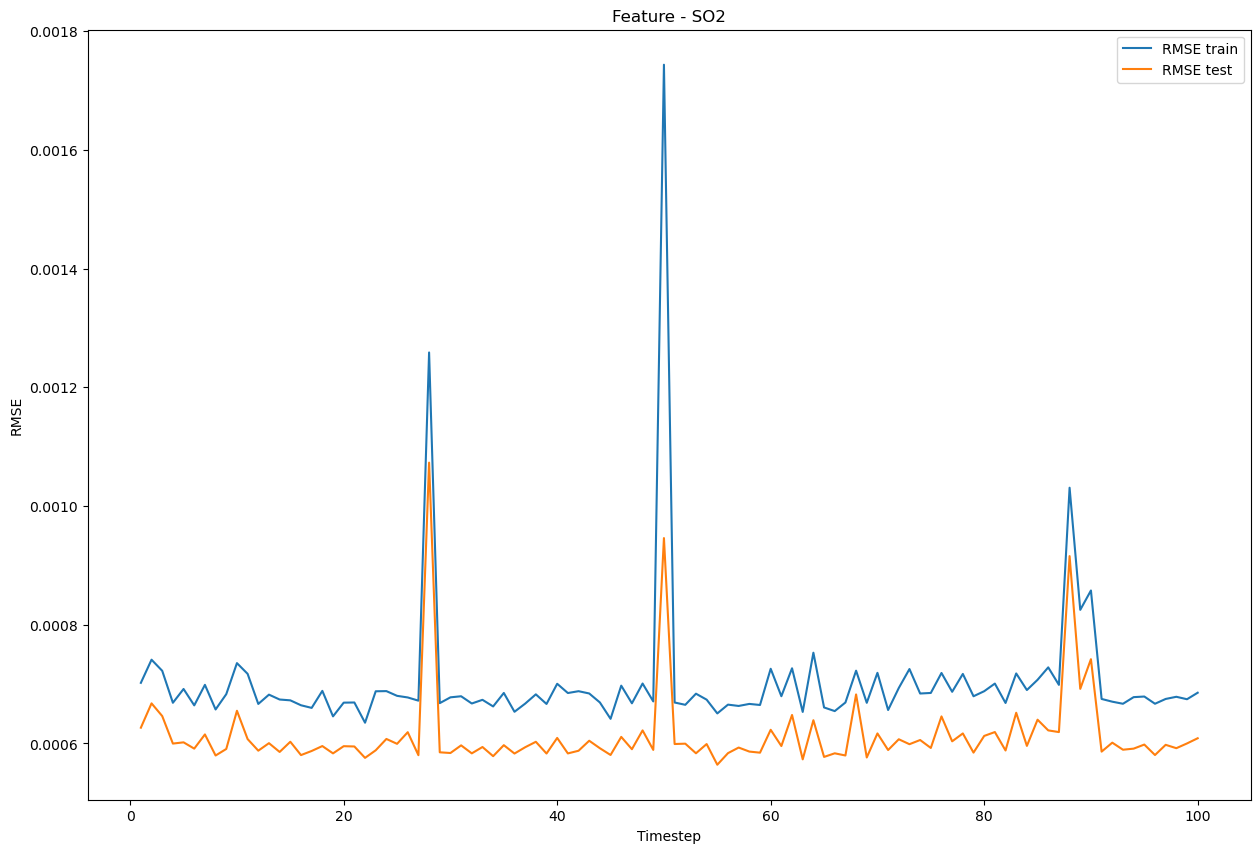

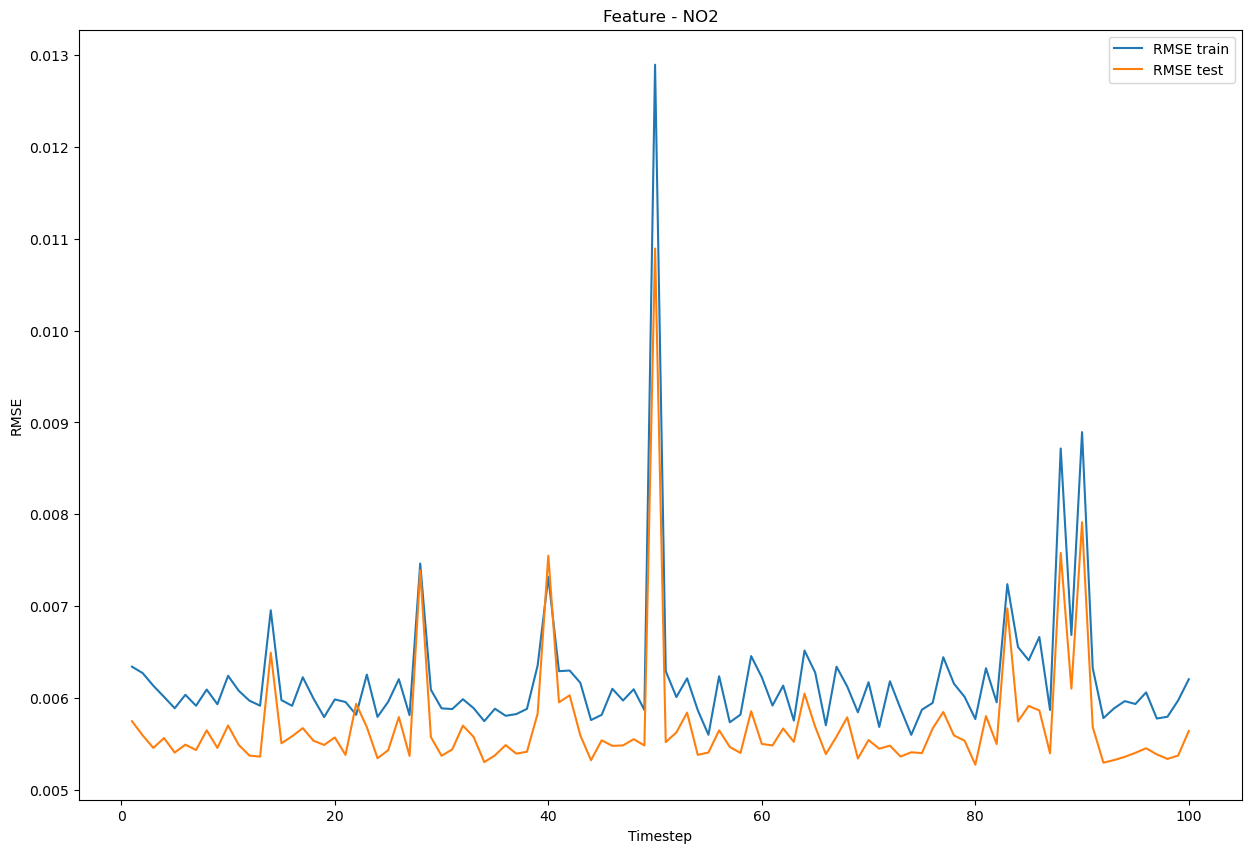

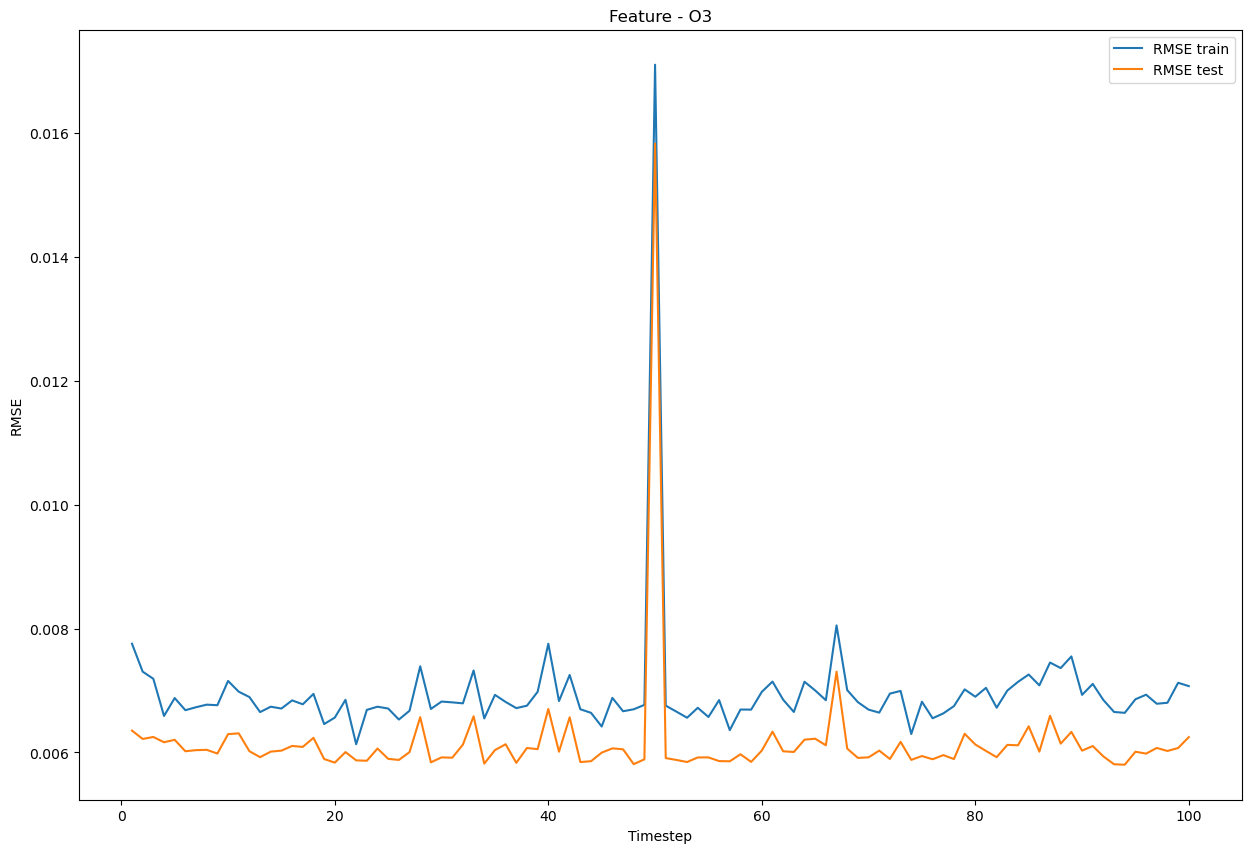

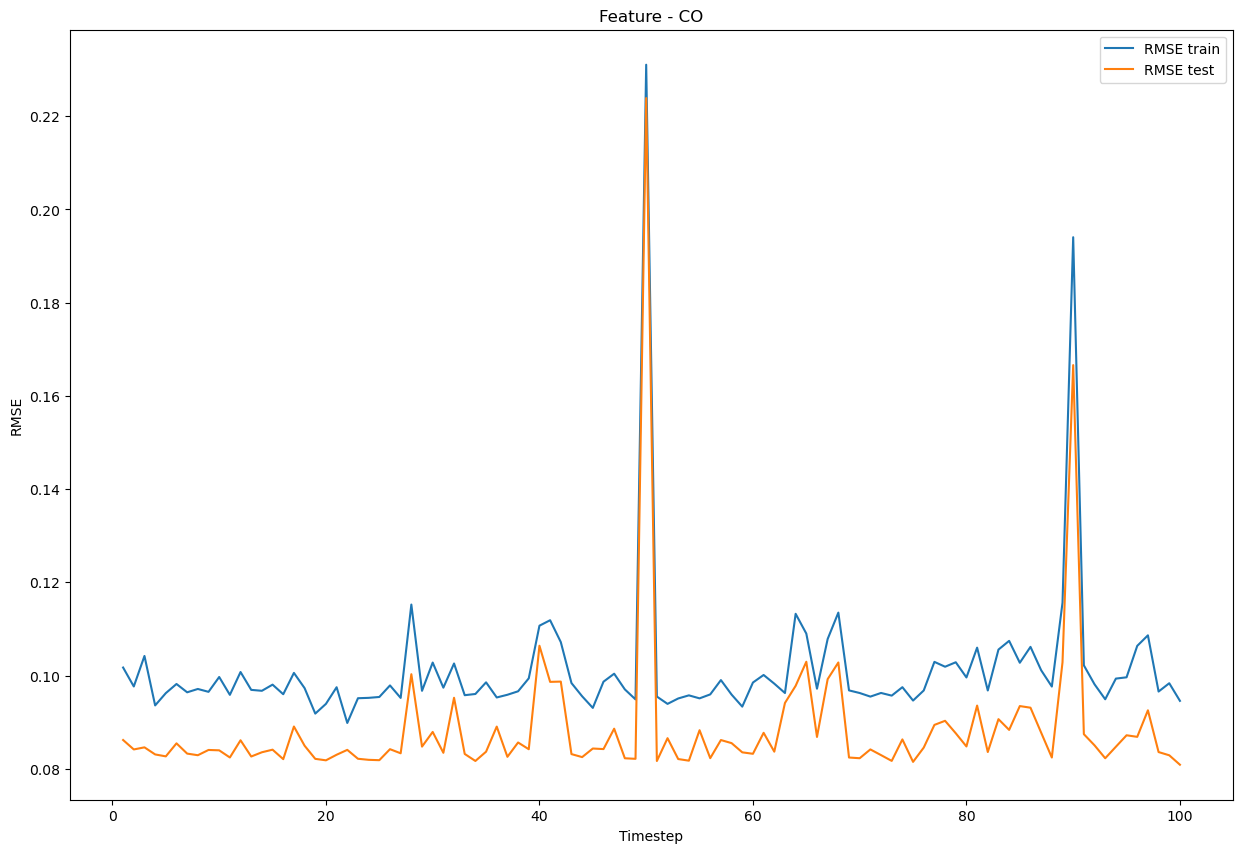

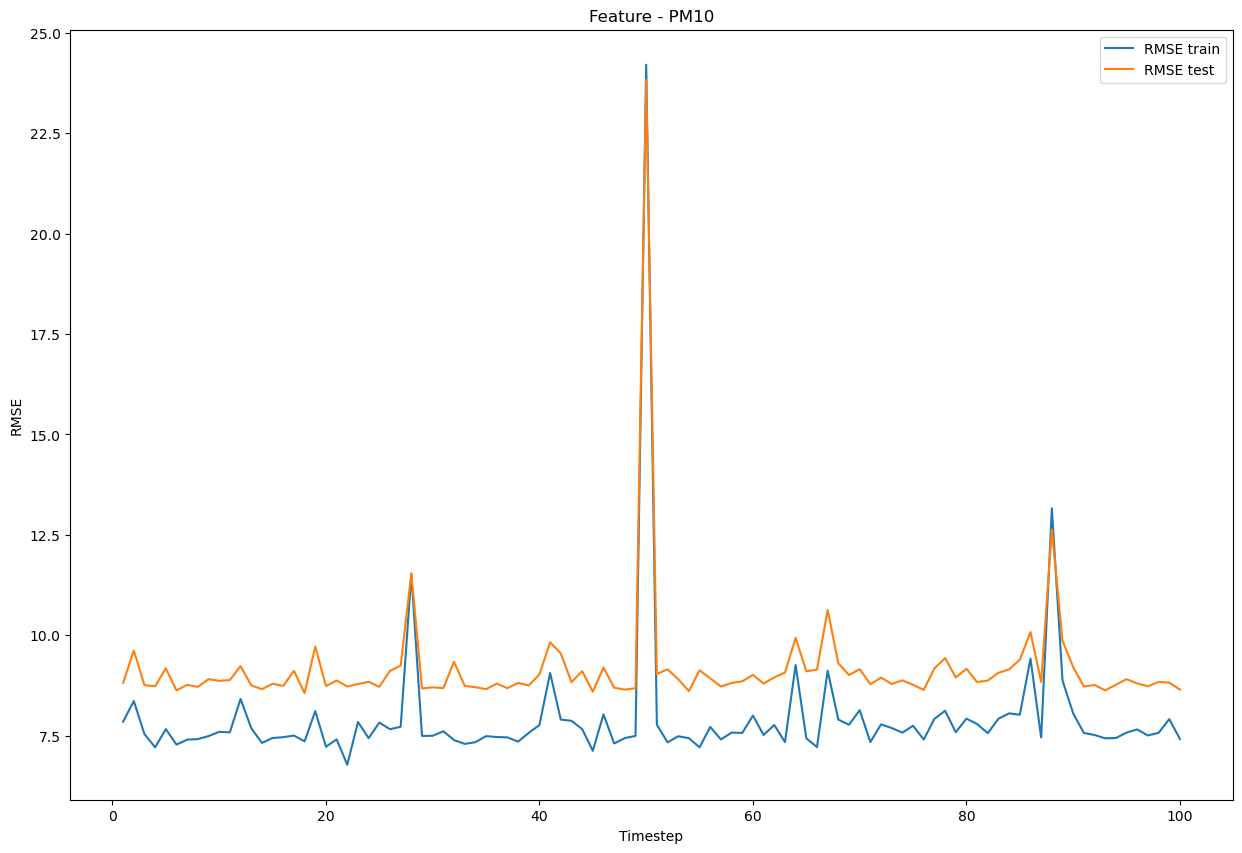

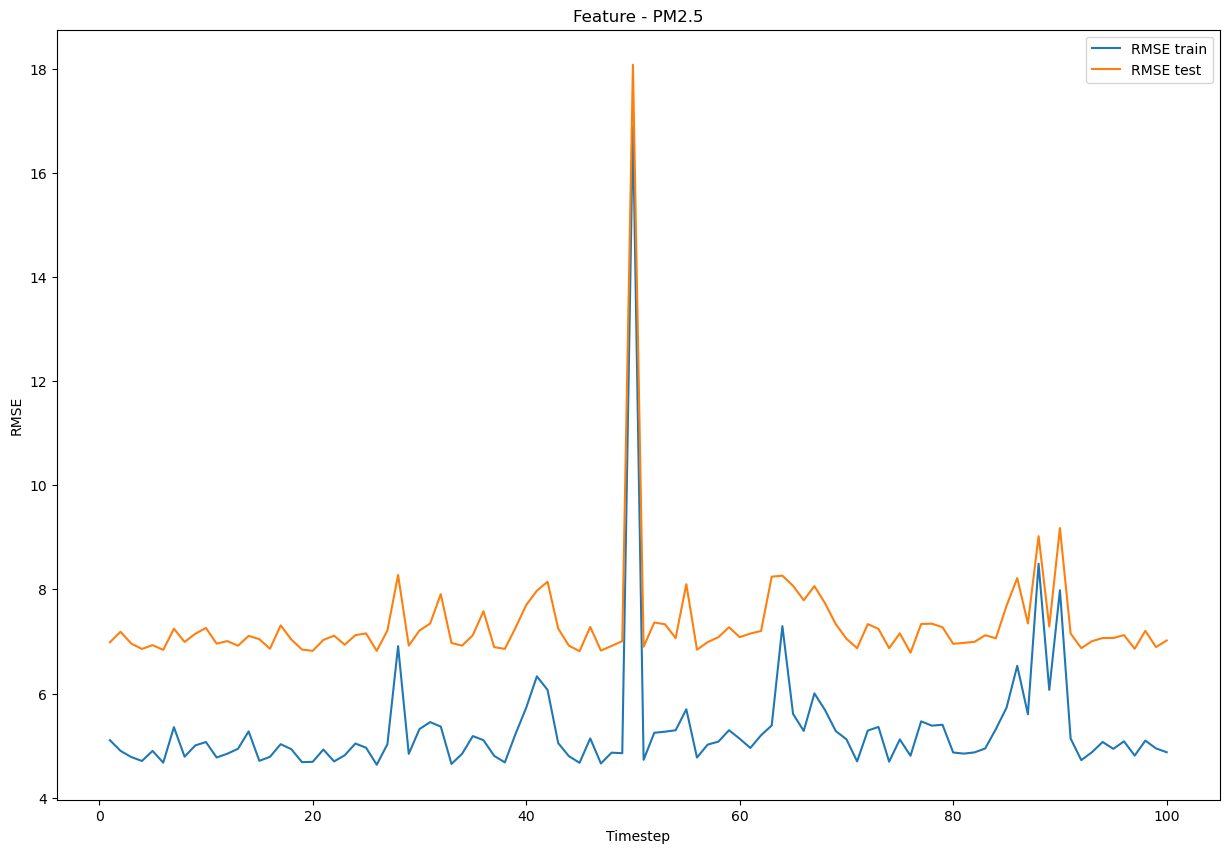

NRMSE


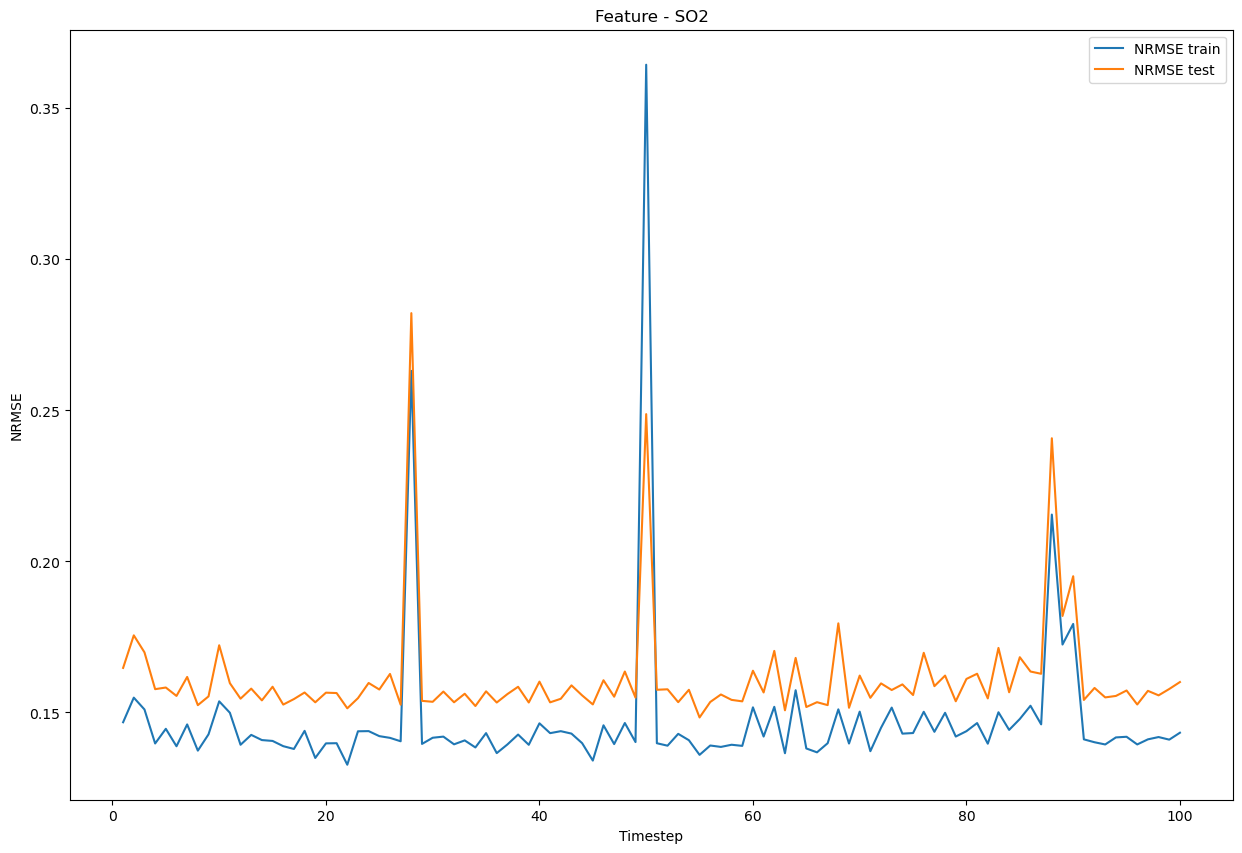

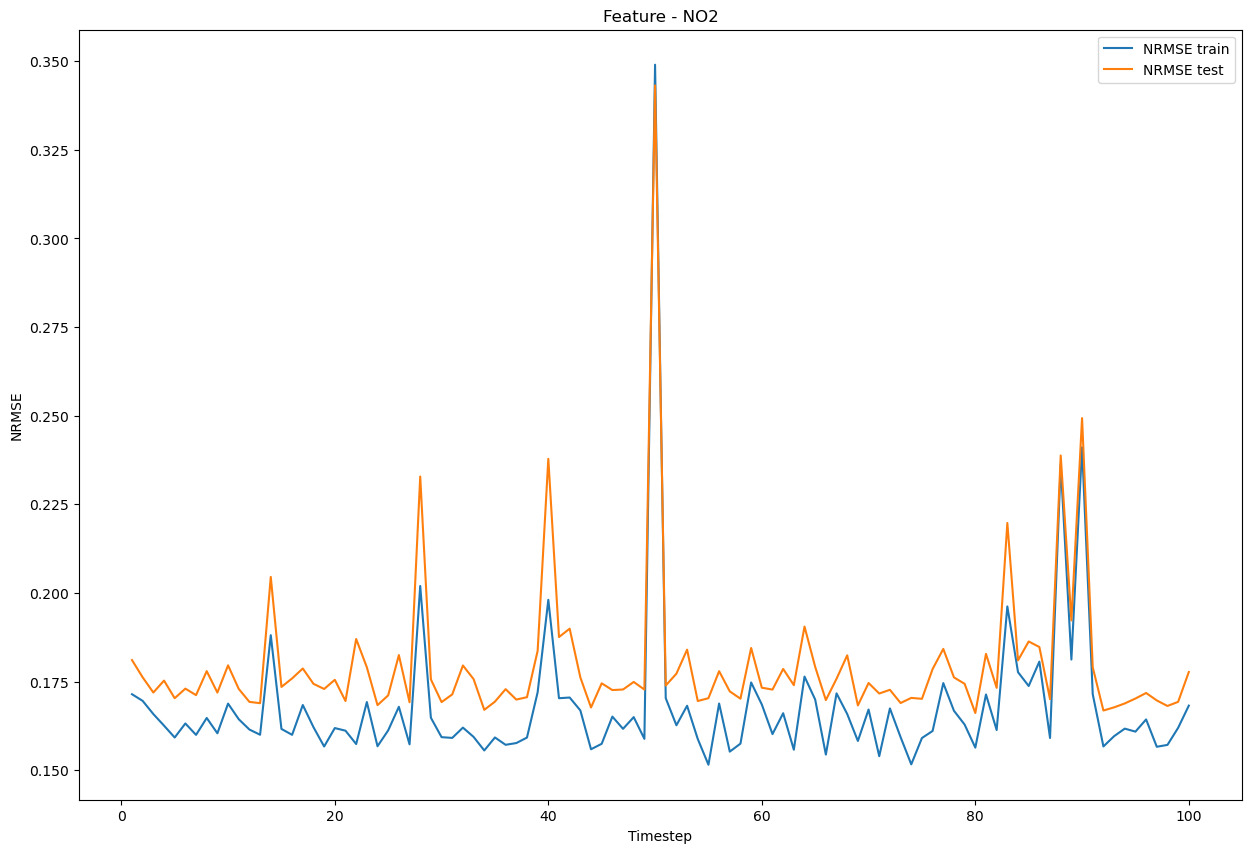

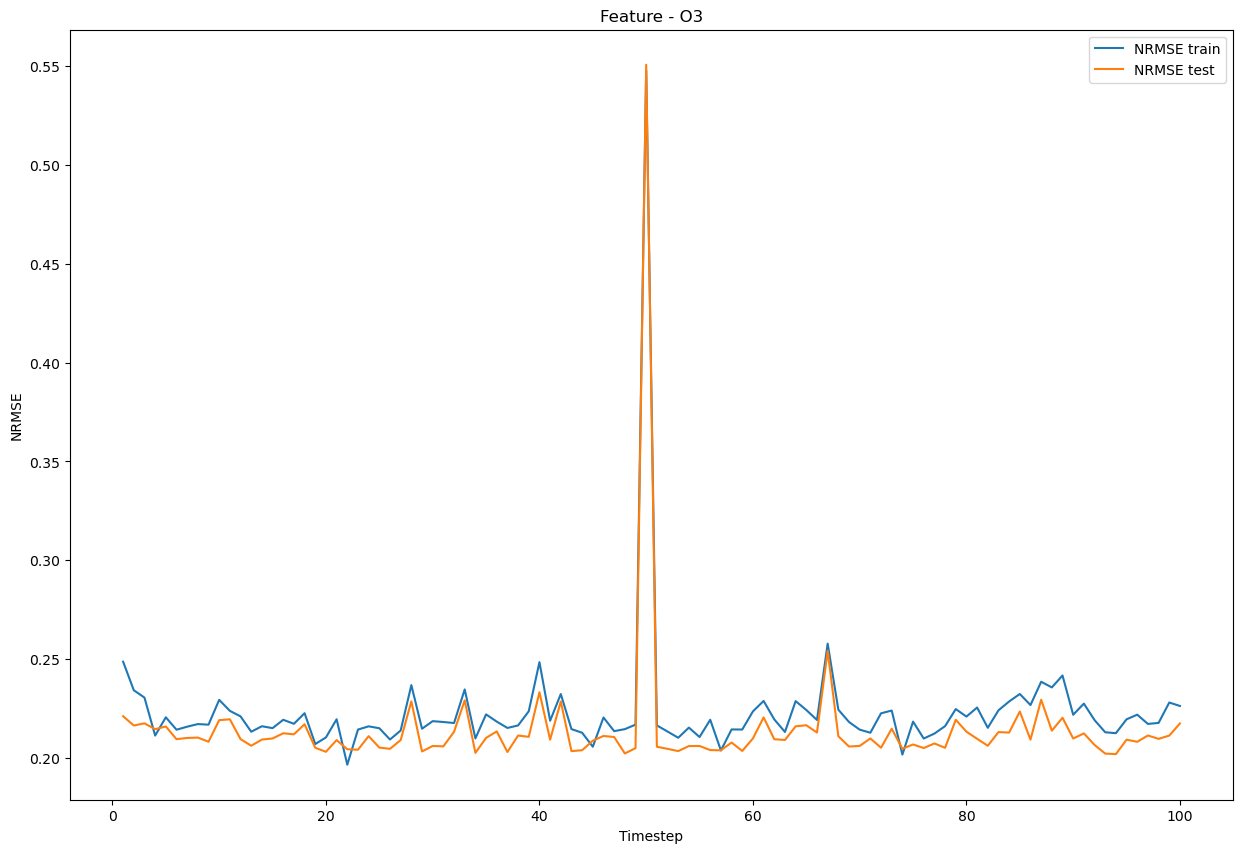

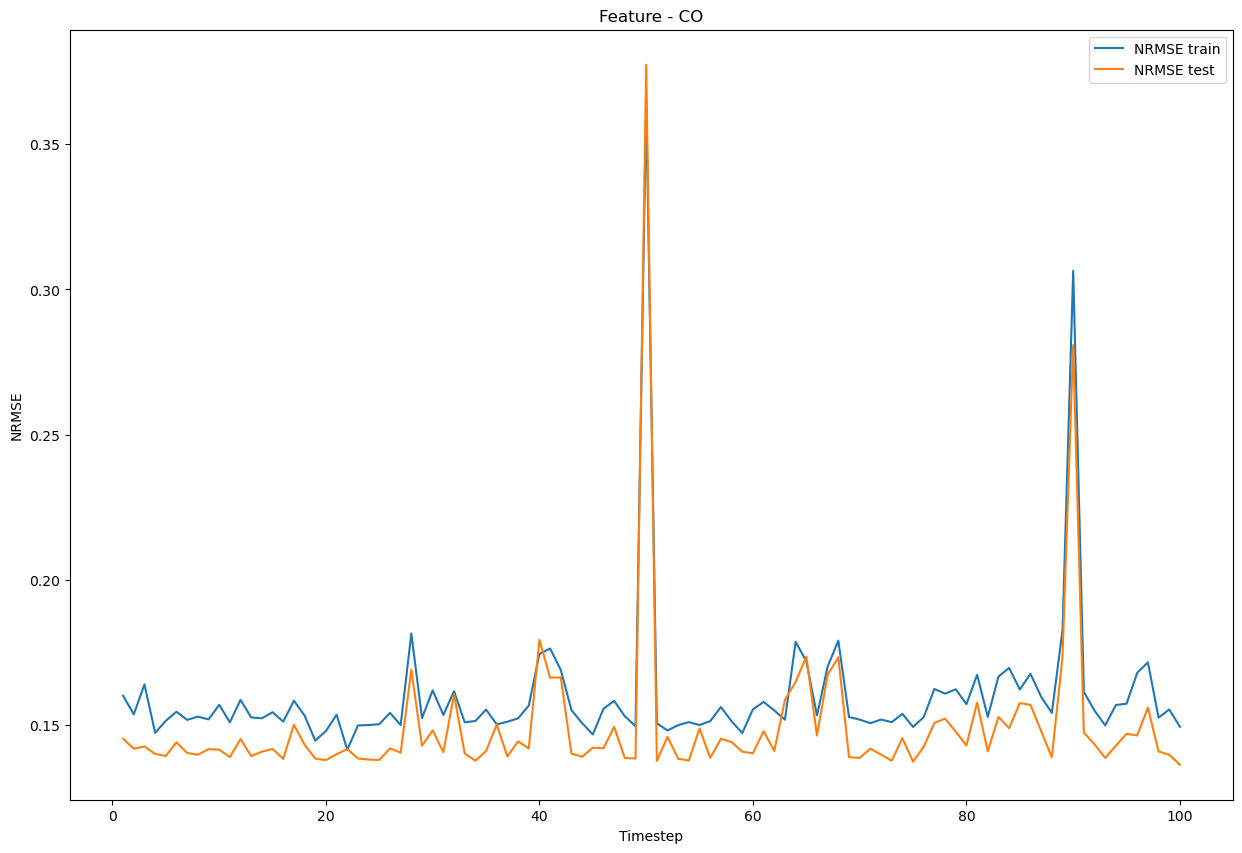

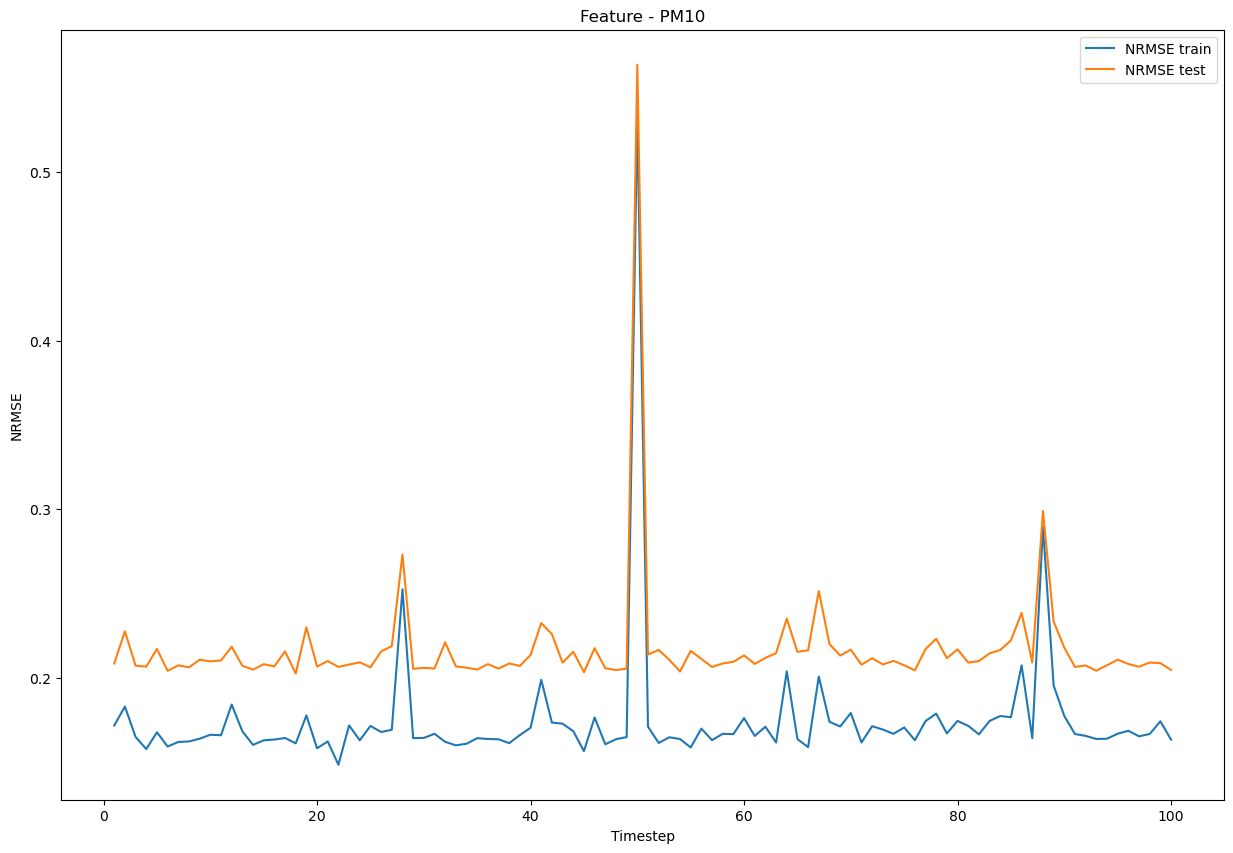

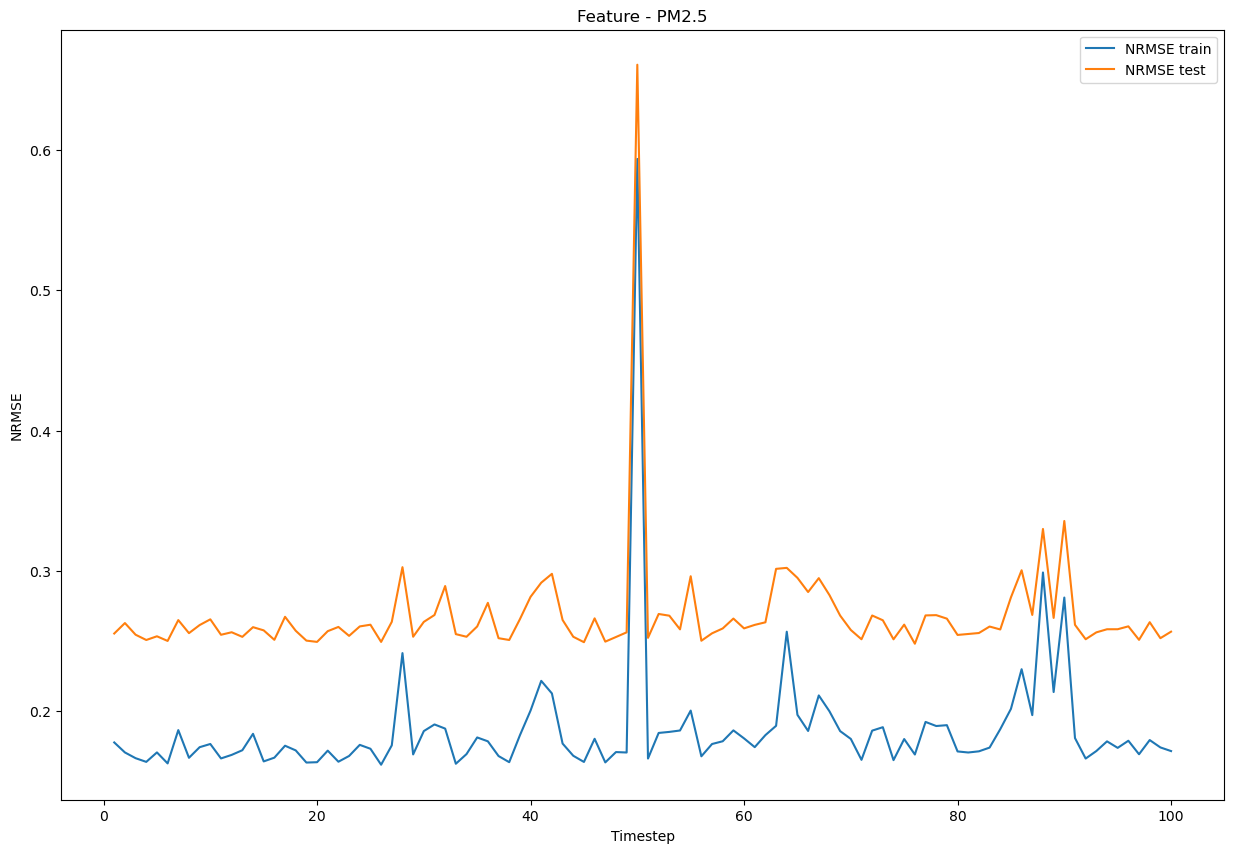

In [12]:
features = df.columns.values
rmse_obs = {}
rmse_pred = {}
nrmse_obs = {}
nrmse_pred = {}
for i in features:
    rmse_obs[i] = []
    rmse_pred[i] = []
    nrmse_obs[i] = []
    nrmse_pred[i] = []

step_of_time = 1
low_ts = 1
high_ts = 100

for indi, time_step in enumerate(range(low_ts, high_ts + 1, step_of_time)):
    
    training_size = int(len(df1)*0.7)
    test_size = len(df1) - training_size
    train_data, test_data = df1[0:training_size,:], df1[training_size - time_step:len(df1),:]
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)
    
    model = create_model(X_train)

    es_callback = keras.callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0, patience = 5)

    history = model.fit(
        X_train,
        y_train,
        validation_data = (X_test, y_test),
        epochs = 100,
        batch_size = 128,
        verbose = 0,
        callbacks = [es_callback]
        )

    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    for i, feature in enumerate(features):
        obj = [j[i] for j in scaler.inverse_transform(y_train)]
        pred = [j[i] for j in scaler.inverse_transform(train_predict)]
        rmse_obs[feature].append(mean_squared_error(obj, pred, squared=False))
        nrmse_obs[feature].append(normalized_root_mse(np.array(obj), np.array(pred)))

        obj = [j[i] for j in scaler.inverse_transform(y_test)]
        pred = [j[i] for j in scaler.inverse_transform(test_predict)]
        rmse_pred[feature].append(mean_squared_error(obj, pred, squared=False))
        nrmse_pred[feature].append(normalized_root_mse(np.array(obj), np.array(pred)))
    

for i in features:
    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(10)
    plt.plot(list(range(low_ts, high_ts + 1, step_of_time)), rmse_obs[i], label = 'RMSE train')
    plt.plot(list(range(low_ts, high_ts + 1, step_of_time)), rmse_pred[i], label = 'RMSE test')
    plt.title(f'Feature - {i}')
    plt.xlabel("Timestep")
    plt.ylabel("RMSE")
    plt.legend()
    plt.show()

print("NRMSE")

for i in features:
    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(10)
    plt.plot(list(range(low_ts, high_ts + 1, step_of_time)), nrmse_obs[i], label = 'NRMSE train')
    plt.plot(list(range(low_ts, high_ts + 1, step_of_time)), nrmse_pred[i], label = 'NRMSE test')
    plt.title(f'Feature - {i}')
    plt.xlabel("Timestep")
    plt.ylabel("NRMSE")
    plt.legend()
    plt.show()
